# 使用 [u-net](https://arxiv.org/abs/1505.04597) 对遥感影像进行非绿地提取

@author:  [sli](mailto:sli@mail.bnu.edu.cn)

目录结构

* [u_net.py](u_net.py) u net 网络结构定义  
* [u_net.train.py](u_net.train.py) 用于训练u net网络  
* [data_loader.py](data_loader.py) 多线程数据加载工具  
* [thread_pool.py](thread_pool.py) 线程池  
* [data/](data/) 数据存放目录  
* [log/](log/) 日志文件目录  
* [models/](models/) 模型权重存放目录  
* [pylibtiff](pylibtiff/) TIFF文件工具（第三方工具包）  
* [preproc_data.ipynb](preproc_data.ipynb) 数据预处理  
* [test_u_net.ipynb](test_u_net.ipynb) 结果查看  




加载u net

In [1]:
import u_net

构建网络计算图

In [2]:
u = u_net.u_net("cpu:0", 0, batch_size=1, output_dim=1)

 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scale of 0 disables regularizer.
 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scale of 0 disables regularizer.
conv_1_1 [1, 572, 572, 64]
 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scale of 0 disables regularizer.
 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scale of 0 disables regularizer.
conv_1_2 [1, 572, 572, 64]
 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scale of 0 disables regularizer.
 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scale of 0 disables regularizer.
conv_2_1 [1, 286, 286, 128]
 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scale of 0 disables regularizer.
 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scale of 0 disables regularizer.
conv_2_2 [1, 286, 286, 128]
 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scale of 0 disables regularizer.
 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scale of 0 disables regularizer.
conv_3_1 [1, 143, 143, 256]
 L2 REGULARIZER SCALE = 0.00000
INFO:tensorflow:Scal

添加必要的数据处理函数和可视化工具

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from libtiff import TIFF
import random
import os
from IPython.display import clear_output

def read_tif(file_path, resize=None, print_log=True):
    """
    
    参数
        file_path tif文件路径
        resize 对加载进来的图片进行resize操作，参数值为(w, h)或(w, h, c)格式的数组。该值默认为None, 表示不进行此项操作。
        print_log 是否打印图片信息 默认True
    """
    tif = TIFF.open(file_path, mode='r')
    image = tif.read_image()
    if not (resize is None):
        image = cv2.resize(image, resize)
    if print_log:
        print(image.shape)
    return image

def load_labelx(file_path, resize, max_value=1.0):
    labelx = read_tif(file_path, resize=resize)
    labelx[labelx < 128] = 0
    labelx[labelx > 128] = 255
    labelx = labelx / (255/max_value)
    return labelx

读取测试数据和真值

In [4]:
data = read_tif("data/test_greenland/test1.tif")
h, w, c = data.shape
label = load_labelx("data/test_greenland/testlabel1.tif", (w, h))

(3068, 3668, 3)
(3068, 3668)


显示真值图片

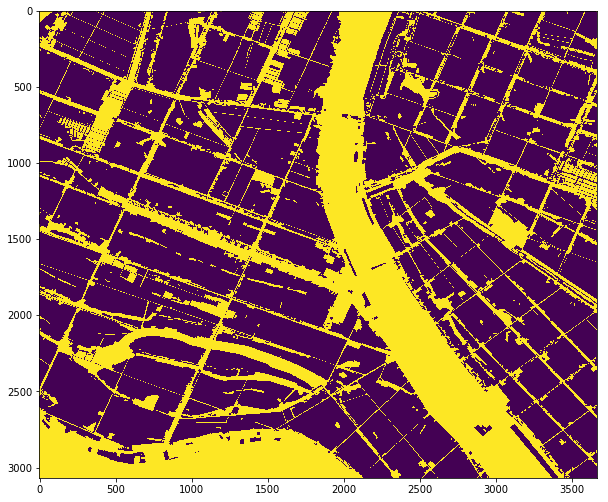

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(label)

加载保存的权重，并执行分割任务

In [6]:
import tensorflow as tf

In [7]:
saver = tf.train.Saver()

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [9]:
saver.restore(sess,tf.train.latest_checkpoint('models/'))

INFO:tensorflow:Restoring parameters from models/u-net.6000-6000


In [10]:
p = sess.run(u.outputs, feed_dict={u.inputs: [cv2.resize(data, (572, 572))]})

分割结果保存在变量p中， 下面的函数用于给定不同阈值t对结果进行二值化处理。同时通过给定真值label，计算4个分割结果的评价指标

In [11]:
def tresult(label, p, t=0.35, copy=False):
    logits = p[0, :, :, 0]
    logits = cv2.resize(logits, (w, h))
    logits[logits < t] = 0.0
    logits[logits > t] = 1.0
    # TP = logits * label, TP + FP = logits, TP + FN = label, FP = logits - logits * label, TN + FP = 1 - label
    l1 = np.sum(logits * label) / np.sum(label) # Recall
    l2 = np.sum(logits * label) / np.sum(logits) # Precision
    l3 = np.sum(logits - logits * label) / np.sum(1 - label) # FPR
    l4 = l1 # TPR
    if copy:
        logits = logits.copy()
    return logits, l1, l2, l3, l4

In [12]:
R = []
P = []
TPR = []
FPR = []
for i in range(101):
    _, l1, l2, l3, l4 = tresult(label, p, 0.01 * i)
    R.append(l1)
    P.append(l2)
    FPR.append(l3)
    TPR.append(l4)

可视化“查全率”和“查准率”曲线

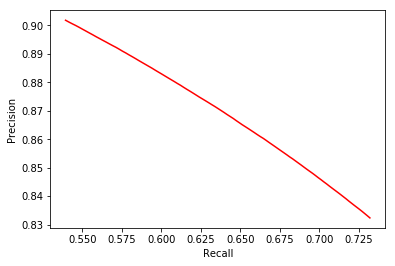

In [13]:
plt.plot(R, P, 'r')
plt.xlabel("Recall")
plt.ylabel("Precision")

可视化“真正例率”和“假正例率”曲线

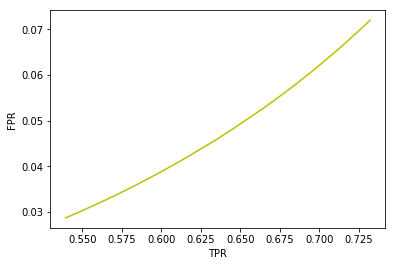

In [14]:
plt.plot(TPR, FPR, 'y')
plt.xlabel("TPR")
plt.ylabel("FPR")

选定一个阈值t获取一个二值化结果

In [15]:
logits, _, _, _, _ = tresult(label, p, 0)
print(logits.shape)

(3068, 3668)


(array([ 8006314.,        0.,        0.,        0.,        0.,        0.,
               0.,  3247110.]),
 array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,  1.   ]),
 <a list of 8 Patch objects>)

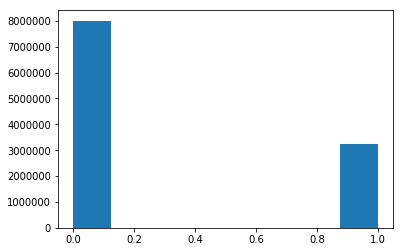

In [16]:
# plt.figure(figsize=(10, 10))
plt.hist(np.ravel(logits), bins=8)

查看分类结果

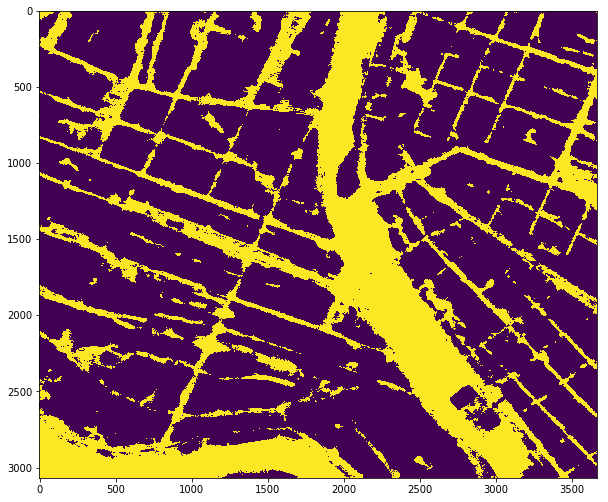

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(logits)

查看原始影像

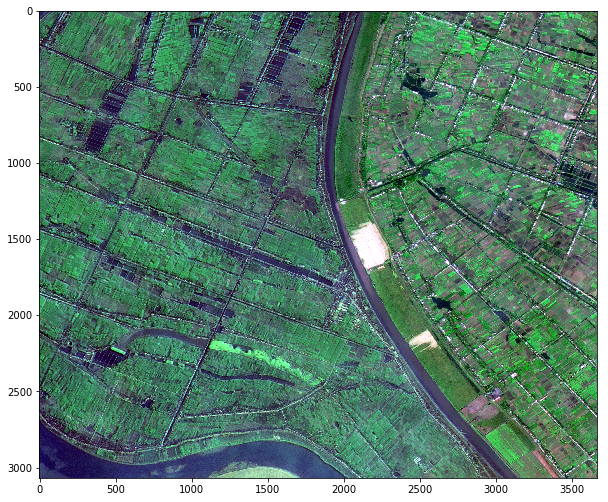

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(data)

查看分割评价图

* 红色：分割遗漏
* 黄色：错误分割
* 白色：正确分割

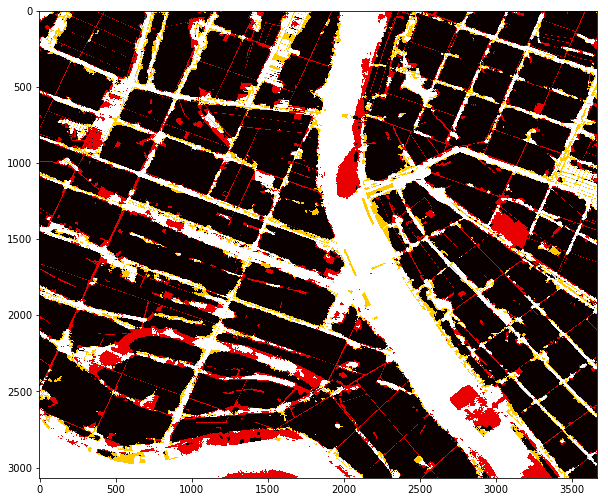

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(2 * logits + label, cmap="hot")

In [20]:
sess.close()